# Improving Classification with LLMs using Prompt Learning

[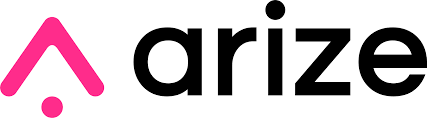](https://arize.com)

In this notebook we will leverage the PromptLearningOptimizer developed here at Arize to improve upon the accuracy of LLMs on classification tasks. Specifically we will be classifying support queries into 30 different classes, including

Account Creation

Login Issues

Password Reset

Two-Factor Authentication

Profile Updates

Billing Inquiry

Refund Request

and 24 more. 

You can view the dataset in support_query_classification/hard_queries.csv.

In [1]:
import os, getpass
import openai
import pandas as pd
from phoenix.evals import OpenAIModel, llm_generate
import re
import pandas as pd
import nest_asyncio
nest_asyncio.apply()

In [2]:
os.environ['OPENAI_API_KEY'] = os.environ['OPENAI_API_KEY'] or getpass.getpass('OpenAI API Key:')

In [3]:
# Add parent directory to path
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# **Setup**

## **Make train/test sets**

In [4]:
data = pd.read_csv("../support_query_classification/hard_queries.csv")
train_set = data.sample(frac=0.8, random_state=42)
test_set = data.drop(train_set.index)

FileNotFoundError: [Errno 2] No such file or directory: '../support_query_classification/hard_queries.csv'

In [ ]:
system_prompt = """You are given a support query:
support query: {query}

Account Creation – Questions about creating a new user account.
Login Issues – Trouble accessing an existing account, including login errors.
Password Reset – Requests to reset or recover a forgotten password.
Two-Factor Authentication – Problems related to 2FA codes or verification steps.
Profile Updates – Questions about changing profile details like email or name.
Billing Inquiry – Questions about charges, billing cycles, or transaction history.
Refund Request – Asking for a refund due to dissatisfaction or error.
Subscription Upgrade/Downgrade – Requests to change the user's subscription plan.
Payment Method Update – Updating or replacing the payment method on file.
Invoice Request – Requests for a copy of an invoice or receipt.
Order Status – Inquiries about the delivery or progress of an order.
Shipping Delay – Reporting or asking about delayed shipments.
Product Return – Requests for returning purchased products.
Warranty Claim – Submitting a claim for defective items under warranty.
Technical Bug Report – Reporting crashes, glitches, or other software bugs.
Feature Request – Suggestions to add or improve product features.
Integration Help – Issues with connecting third-party services or tools.
Data Export – Requests to download or export personal or usage data.
Security Concern – Reporting suspicious activity or potential security issues.
Terms of Service Question – Questions about cancellation, usage rules, or rights.
Privacy Policy Question – Questions about how user data is collected or used.
Compliance Inquiry – Questions about legal compliance (e.g., GDPR, CCPA).
Accessibility Support – Requests for help using the service with a disability.
Language Support – Questions about multilingual support or language settings.
Mobile App Issue – Problems specifically with the mobile version of the app.
Desktop App Issue – Issues related to the desktop version or installation.
Email Notifications – Not receiving expected emails such as confirmations.
Marketing Preferences – Requests to manage or stop promotional emails.
Beta Program Enrollment – Interest in joining early access or beta programs.
General Feedback – General praise, criticism, or user suggestions.



Return just the category, no other text.
"""

## **Output Generator**

This function calls OpenAI with our prompt on every row of our dataset to generate outputs. It leverages llm_generate, a Phoenix function, for concurrency in calling LLMs. 

We return the output column, which contains outputs for every row of our dataset, or every support query in our dataset. 

In [ ]:
def generate_output(dataset, system_prompt):
    output_model = OpenAIModel(
        model="gpt-4o-mini-2024-07-18",
        model_kwargs={
            "temperature": 0
        }
    )
    outputs = llm_generate(
        dataframe=dataset,
        template=system_prompt,
        model=output_model,
        concurrency=40,
        verbose=True
    )
    return outputs["output"]

## **Evaluator**

In this section we define our LLM-as-judge eval. 

Prompt Learning works by generating natural language evaluations on your outputs. These evaluations help guide the prompt optimizer towards building an optimized prompt. 

You should spend time thinking about how to write an informative eval. Your eval makes or breaks this prompt optimizer. With helpful feedback, our prompt optimizer will be able to generate a stronger optimized prompt much more effectively than with sparse or unhelpful feedback. 

Below is a great example for building a strong eval. You can see that we return many evaluations, including
- **correctness**: correct/incorrect - whether the support query was classified correctly or incorrectly.

-  **explanation**: Brief explanation of why the predicted classification is correct or incorrect, referencing the correct label if relevant.

-  **confusion_reason**: If incorrect, explains why the model may have made this choice instead of the correct classification. Focuses on likely sources of confusion. If correct, 'no confusion'.

-  **error_type**: One of: 'broad_vs_specific', 'keyword_bias', 'multi_intent_confusion', 'ambiguous_query', 'off_topic', 'paraphrase_gap', 'other'. Use 'none' if correct. Include the definition of the chosen error type, which are passed into the evaluator's prompt. 

-  **top_3_classes**: [Best match class, Second best match class, Third best match class]

-  **ground_truth**: The correct classification

-  **evidence_span**: Exact phrase(s) from the query that strongly indicate the correct classification.

-  **prompt_fix_suggestion**: One clear instruction to add to the classifier prompt to prevent this error.

**Take a look at support_query_classification/evaluator_prompt.txt for the full prompt!**

In [ ]:
def find_attributes(output):
    """Extract fields from evaluator output"""
    correctness_pattern = r'"correctness":\s*"([^"]*)"'
    explanation_pattern = r'"explanation":\s*"([^"]*)"'
    confusion_reason_pattern = r'"confusion_reason":\s*"([^"]*)"'
    error_type_pattern = r'"error_type":\s*"([^"]*)"'
    top_3_classes_pattern = r'"top_3_classes":\s*\[(.*?)\]'
    evidence_span_pattern = r'"evidence_span":\s*"([^"]*)"'
    prompt_fix_suggestion_pattern = r'"prompt_fix_suggestion":\s*"([^"]*)"'
    
    match_correctness = re.search(correctness_pattern, output, re.IGNORECASE)
    match_explanation = re.search(explanation_pattern, output, re.IGNORECASE)
    match_confusion_reason = re.search(confusion_reason_pattern, output, re.IGNORECASE)
    match_error_type = re.search(error_type_pattern, output, re.IGNORECASE)
    match_top_3_classes = re.search(top_3_classes_pattern, output, re.IGNORECASE)
    match_evidence_span = re.search(evidence_span_pattern, output, re.IGNORECASE)
    match_prompt_fix_suggestion = re.search(prompt_fix_suggestion_pattern, output, re.IGNORECASE)
    correctness = match_correctness.group(1) if match_correctness else None
    explanation = match_explanation.group(1) if match_explanation else None
    confusion_reason = match_confusion_reason.group(1) if match_confusion_reason else None
    error_type = match_error_type.group(1) if match_error_type else None
    top_3_classes = match_top_3_classes.group(1) if match_top_3_classes else None
    evidence_span = match_evidence_span.group(1) if match_evidence_span else None
    prompt_fix_suggestion = match_prompt_fix_suggestion.group(1) if match_prompt_fix_suggestion else None
    return correctness, explanation, confusion_reason, error_type, top_3_classes, evidence_span, prompt_fix_suggestion

def output_parser(response: str, row_index: int) -> dict:
    correctness, explanation, confusion_reason, error_type, top_3_classes, evidence_span, prompt_fix_suggestion = find_attributes(response)
    return {
        "correctness": correctness,
        "explanation": explanation,
        "confusion_reason": confusion_reason,
        "error_type": error_type,
        "top_3_classes": top_3_classes,
        "evidence_span": evidence_span,
        "prompt_fix_suggestion": prompt_fix_suggestion
    }

def output_evaluator(dataset):
    with open("../support_query_classification/evaluator_prompt.txt", "r") as file:
        evaluator_prompt = file.read()

    eval_model = OpenAIModel(
        model="o3-2025-04-16",
        model_kwargs={
            "response_format": {"type": "json_object"},
        }
    )

    evaluation_results = llm_generate(
        dataframe=dataset,
        template=evaluator_prompt,
        model=eval_model,
        output_parser=output_parser,
        concurrency=40,
        verbose=True
    )

    dataset = dataset.copy()
    feedback_columns = ["correctness", "explanation", "confusion_reason", "error_type", "top_3_classes", "evidence_span", "prompt_fix_suggestion"]
    for col in feedback_columns:
        if col in evaluation_results.columns:
            dataset[col] = evaluation_results[col]

    return dataset, feedback_columns

llm_generate |██████████| 31/31 (100.0%) | ⏳ 00:20<00:00 |  1.51it/s


## Metrics

Below we define some metrics that will compute on each iteration of prompt optimization. It will help us measure how our classifier with the current iteration's prompt performs.

Specifically we use scikit learn for precision, recall, f1 score, and simple accuracy.

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def compute_metric(y_pred, y_true, scorer="accuracy", average="macro"):
    """
    Compute the requested metric for multiclass classification.
    """
    if scorer == "accuracy":
        return accuracy_score(y_true, y_pred)
    elif scorer == "f1":
        return f1_score(y_true, y_pred, zero_division=0, average=average)
    elif scorer == "precision":
        return precision_score(y_true, y_pred, zero_division=0, average=average)
    elif scorer == "recall":
        return recall_score(y_true, y_pred, zero_division=0, average=average)
    else:
        raise ValueError(f"Unknown scorer: {scorer}")

# **Optimization**

## **Optimization Loop**

Below are the steps taken to optimize the prompt.

**0. Baseline Evaluation**  
- Test the base prompt on the **test set**.  
- Compute metrics (precision, recall, F1, accuracy).  
- If performance meets the target threshold, skip optimization.  

**1. Feedback Generation**  
- Run the evaluator on the **training set**.  
- Generate natural language feedback for the prompt optimizer.  

**2. Prompt Optimization**  
- Pass the feedback to the prompt optimizer, `PromptLearningOptimizer`  
- Generate a new optimized prompt.  

**3. Training Evaluation**  
- Test the optimized prompt on the **training set**.  
- Compute metrics (precision, recall, F1, accuracy).  

**4. Test Evaluation**  
- Test the optimized prompt on the **test set**.  
- Compute metrics (precision, recall, F1, accuracy).  

**5. Iteration Check**  
- If **test metrics** meet the target threshold → stop.  
- Otherwise → repeat steps 1–5 until:  
  - Threshold is met, or  
  - Maximum iteration count is reached.


In [ ]:
from optimizer_sdk.prompt_learning_optimizer import PromptLearningOptimizer

def optimize_loop(
    train_set,
    test_set,
    system_prompt,
    evaluators,
    threshold=1,
    loops=5,
    scorer="accuracy",
):
    """
    scorer: one of "accuracy", "f1", "precision", "recall"
    threshold: float, threshold for the selected metric
    """
    import copy
    curr_loop = 1
    train_metrics = []
    test_metrics = []
    prompts = []
    raw_dfs = []

    print(f"🚀 Starting prompt optimization with {loops} iterations (scorer: {scorer}, threshold: {threshold})")
    
    print(f"📊 Initial evaluation:")
    test_set["output"] = generate_output(test_set, system_prompt)
    initial_metric_value = compute_metric(test_set["output"], test_set["ground_truth"], scorer)
    print(f"✅ Initial {scorer}: {initial_metric_value}")

    test_metrics.append(initial_metric_value)
    prompts.append(system_prompt)
    raw_dfs.append(copy.deepcopy(test_set))

    if initial_metric_value >= threshold:
        print("🎉 Initial prompt already meets threshold!")
        return {
            "train": train_metrics,
            "test": test_metrics,
            "prompt": prompts,
            "raw": raw_dfs
        }
    
    # Initialize all feedback columns
    feedback_columns = ["correctness", "explanation", "confusion_reason", "error_type", "top_3_classes", "evidence_span", "prompt_fix_suggestion"]
    for col in feedback_columns:
        train_set[col] = [None for _ in range(len(train_set))]
    
    while loops > 0:
        print(f"📊 Loop {curr_loop}: Optimizing prompt...")
        train_set["output"] = generate_output(train_set, system_prompt)

        optimizer = PromptLearningOptimizer(
            prompt=system_prompt,
            model_choice="o3-2025-04-16",
            openai_api_key=os.getenv("OPENAI_API_KEY")
        )

        train_set, _ = optimizer.run_evaluators(
            train_set,
            evaluators,
            feedback_columns=feedback_columns
        )

        with open("../support_query_classification/annotations_prompt.txt", "r") as file:
            annotations_prompt = file.read()

        annotations = optimizer.create_annotation(
            system_prompt,
            ["query"],
            train_set,
            feedback_columns,
            [annotations_prompt],
            "output",
            "ground_truth"
        )

        system_prompt = optimizer.optimize(
            train_set,
            "output",
            feedback_columns=feedback_columns,
            context_size_k=90000,
            annotations=annotations,
        )

        prompts.append(system_prompt)

        train_metric_post_value = compute_metric(train_set["output"], train_set["ground_truth"], scorer)
        train_metrics.append(train_metric_post_value)
        print(f"✅ Train {scorer}: {train_metric_post_value}")

        test_set["output"] = generate_output(test_set, system_prompt)
        test_metric_post_value = compute_metric(test_set["output"], test_set["ground_truth"], scorer)
        test_metrics.append(test_metric_post_value)
        print(f"✅ Test {scorer}: {test_metric_post_value}")

        if test_metric_post_value >= threshold:
            print("🎉 Prompt optimization met threshold!")
            break

        loops -= 1
        curr_loop += 1

    return {
            "train": train_metrics,
            "test": test_metrics,
            "prompts": prompts,
            "raw": raw_dfs
        }


evaluators = [output_evaluator]
result = optimize_loop(train_set, test_set, system_prompt, evaluators, loops=5, scorer="accuracy")


🚀 Starting prompt optimization with 5 iterations (scorer: accuracy, threshold: 1)
📊 Initial evaluation:


/opt/anaconda3/envs/base2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
llm_generate |██████████| 31/31 (100.0%) | ⏳ 00:05<00:00 |  6.06it/s


✅ Initial accuracy: 0.45161290322580644
📊 Loop 1: Optimizing prompt...


llm_generate |██████████| 123/123 (100.0%) | ⏳ 00:13<00:00 |  9.20it/s


🔍 Running 1 evaluator(s)...


   ✅ Evaluator 1: prompt_fix_suggestion
🔍 Running annotator...
['query', 'ground_truth', 'correctness', 'explanation', 'confusion_reason', 'error_type', 'top_3_classes', 'evidence_span', 'prompt_fix_suggestion', 'output']

🔧 Creating batches with 90,000 token limit
📊 Processing 123 examples in 1 batches


llm_generate |██████████| 123/123 (100.0%) | ⏳ 01:30<00:00 |  1.36it/s


   ✅ Batch 1/1: Optimized
✅ Train accuracy: 0.5121951219512195


/opt/anaconda3/envs/base2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
llm_generate |██████████| 31/31 (100.0%) | ⏳ 00:04<00:00 |  6.66it/s


✅ Test accuracy: 0.45161290322580644
📊 Loop 2: Optimizing prompt...


llm_generate |██████████| 123/123 (100.0%) | ⏳ 00:14<00:00 |  8.47it/s

🔍 Running 1 evaluator(s)...


























llm_generate |██████████| 123/123 (100.0%) | ⏳ 14:09<00:00 |  6.91s/it





























































                                                                


Worker timeout, requeuing


   ✅ Evaluator 1: prompt_fix_suggestion
🔍 Running annotator...
['query', 'ground_truth', 'correctness', 'explanation', 'confusion_reason', 'error_type', 'top_3_classes', 'evidence_span', 'prompt_fix_suggestion', 'output']

🔧 Creating batches with 90,000 token limit
📊 Processing 123 examples in 1 batches


llm_generate |██████████| 123/123 (100.0%) | ⏳ 03:01<00:00 |  1.48s/it


   ✅ Batch 1/1: Optimized
✅ Train accuracy: 0.5772357723577236


llm_generate |██████████| 31/31 (100.0%) | ⏳ 00:04<00:00 |  4.88it/s/opt/anaconda3/envs/base2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
/opt/anaconda3/envs/base2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(y_pred, input_name="y_pred")
llm_generate |██████████| 31/31 (100.0%) | ⏳ 00:05<00:00 |  5.53it/s


✅ Test accuracy: 0.41935483870967744
📊 Loop 3: Optimizing prompt...


llm_generate |██████████| 123/123 (100.0%) | ⏳ 00:19<00:00 |  6.44it/s

🔍 Running 1 evaluator(s)...


   ✅ Evaluator 1: prompt_fix_suggestion
🔍 Running annotator...
['query', 'ground_truth', 'correctness', 'explanation', 'confusion_reason', 'error_type', 'top_3_classes', 'evidence_span', 'prompt_fix_suggestion', 'output']

🔧 Creating batches with 90,000 token limit
📊 Processing 123 examples in 1 batches


llm_generate |██████████| 123/123 (100.0%) | ⏳ 01:35<00:00 |  1.29it/s


   ✅ Batch 1/1: Optimized
✅ Train accuracy: 0.5609756097560976


llm_generate |██████████| 31/31 (100.0%) | ⏳ 00:04<00:00 |  4.74it/s/opt/anaconda3/envs/base2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
/opt/anaconda3/envs/base2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(y_pred, input_name="y_pred")
llm_generate |██████████| 31/31 (100.0%) | ⏳ 00:05<00:00 |  5.55it/s


✅ Test accuracy: 0.4838709677419355
📊 Loop 4: Optimizing prompt...


llm_generate |███████▋  | 94/123 (76.4%) | ⏳ 00:09<00:03 |  9.07it/s 

Exception in worker on attempt 1: raised InternalServerError('upstream connect error or disconnect/reset before headers. reset reason: connection termination')
Requeuing...


llm_generate |█████████▉| 122/123 (99.2%) | ⏳ 00:12<00:00 | 11.19it/s

🔍 Running 1 evaluator(s)...


llm_generate |██████████| 123/123 (100.0%) | ⏳ 00:31<00:00 | 11.19it/s

   ✅ Evaluator 1: prompt_fix_suggestion
🔍 Running annotator...
['query', 'ground_truth', 'correctness', 'explanation', 'confusion_reason', 'error_type', 'top_3_classes', 'evidence_span', 'prompt_fix_suggestion', 'output']

🔧 Creating batches with 90,000 token limit
📊 Processing 123 examples in 1 batches


llm_generate |██████████| 123/123 (100.0%) | ⏳ 01:50<00:00 |  1.11it/s


   ✅ Batch 1/1: Optimized
✅ Train accuracy: 0.5528455284552846


/opt/anaconda3/envs/base2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
/opt/anaconda3/envs/base2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(y_pred, input_name="y_pred")
llm_generate |██████████| 31/31 (100.0%) | ⏳ 00:05<00:00 |  5.53it/s


✅ Test accuracy: 0.5806451612903226
📊 Loop 5: Optimizing prompt...


llm_generate |██████████| 123/123 (100.0%) | ⏳ 00:13<00:00 |  9.37it/s

🔍 Running 1 evaluator(s)...































                                                                       

llm_generate |██████████| 123/123 (100.0%) | ⏳ 02:39<00:00 | 11.19it/s
                                                                       

llm_generate |██████████| 123/123 (100.0%) | ⏳ 02:39<00:00 | 11.19it/s



Exception in worker on attempt 1: raised InternalServerError('upstream connect error or disconnect/reset before headers. reset reason: connection timeout')
Requeuing...


   ✅ Evaluator 1: prompt_fix_suggestion
🔍 Running annotator...
['query', 'ground_truth', 'correctness', 'explanation', 'confusion_reason', 'error_type', 'top_3_classes', 'evidence_span', 'prompt_fix_suggestion', 'output']

🔧 Creating batches with 90,000 token limit
📊 Processing 123 examples in 1 batches
   ✅ Batch 1/1: Optimized
✅ Train accuracy: 0.6341463414634146


✅ Test accuracy: 0.41935483870967744


/opt/anaconda3/envs/base2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
/opt/anaconda3/envs/base2/lib/python3.12/site-packages/sklearn/metrics/_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(y_pred, input_name="y_pred")


# Prompt Optimized!

The code below picks the prompt with the highest score on the test set, and displays the training/test metrics and delta for that prompt.

In [ ]:
# Find the best index based on highest test accuracy
best_idx = max(range(len(result["test"])), key=lambda i: result["test"][i])

# Retrieve values
best_prompt = result["prompts"][best_idx - 1]
best_test_acc = result["test"][best_idx]
best_train_acc = result["train"][best_idx - 1] if (best_idx - 1) < len(result["train"]) else None
initial_test_acc = result["test"][0]
initial_train_acc = result["train"][0] if result["train"] else None

# Print results
print("\n🔍 Best Prompt Found:")
print(best_prompt)
print(f"🏋️ Train Accuracy: {best_train_acc} (Δ {best_train_acc - initial_train_acc:.4f})" if best_train_acc is not None else "Train accuracy not available")
print(f"🧪 Test Accuracy: {best_test_acc} (Δ {best_test_acc - initial_test_acc:.4f})")



🔍 Best Prompt Found:
You are a customer-support ticket classifier.

INPUT  
support query: {query}

TASK  
Read the entire message, identify the user’s single primary intent, and output the one best-matching category name from the list below.  
Return ONLY that name—no other words, numbers, or punctuation.

GENERAL RULES  
1. Output must be one (and only one) name that appears verbatim in the Category List. Never invent or shorten names.  
2. Choose the most specific class that solves the user’s main problem; prefer the child over its parent.  
3. Use full-message meaning, not isolated keywords. If words conflict with context, trust the context.  
4. When several issues are mentioned, pick the one the user wants fixed first (usually the obstacle blocking them now).  
5. If intent is unclear after careful reading, pick the most probable class—not “General Feedback”.  
6. Slang, typos, emojis, or missing words still map to their standard meaning.

COMMON DECISION PIVOTS  
• RETURN / EXC